In [2]:
from ase.io import read
#from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import pandas as pd

In [2]:
#conda install -c rdkit rdkit
#pip install ase
#pip install rdkit-
#pip install py3Dmol

In [3]:
from rdkit import Chem
#from rdkit.Chem import rdDistGeom, AllChem
#from rdkit.Geometry import Point3D

#### Functions for node featuring

In [6]:
def pandas_molecule(file_name):
    """
    Load the molecule from pdb format
    and return some of the pdb information
    in pandas format
    """
    # Loading molecule
    atoms = read(file_name, format="proteindatabank")
    # Convert to pandas DataFrame
    atoms_pdb = pd.DataFrame({
        'atom': atoms.get_chemical_symbols(),
        # Optional: add residue info if available in PDB
        'residue': atoms.get_array('residuenames') if 'residuenames' in atoms.arrays else None,
        'x': atoms.positions[:, 0],
        'y': atoms.positions[:, 1],
        'z': atoms.positions[:, 2]
    })
    # Remove blank spaces from 'residue' column
    atoms_pdb['residue'] = atoms_pdb['residue'].str.strip()
    return atoms_pdb

In [7]:
def atom_categorical_feat(pandas_mol):
    """
    Receive a pandas matrix that contains the basic
    information of a pdb file: atom, residue, x, y, z.
    It appends, as new binary columns, the type of atom
    in the following order: 'C', 'N', 'O', 'H' and 'S',
    where 1 if the atom is of that type and 0 otherwise.
    """
    pandas_mol['C'] = (pandas_mol['atom'].eq('C')).astype(int)
    pandas_mol['N'] = (pandas_mol['atom'].eq('N')).astype(int)
    pandas_mol['O'] = (pandas_mol['atom'].eq('O')).astype(int)
    pandas_mol['H'] = (pandas_mol['atom'].eq('H')).astype(int)
    pandas_mol['S'] = (pandas_mol['atom'].eq('S')).astype(int)
    return pandas_mol

In [8]:
def res_categorical_feat(pandas_mol):
    """
    Receive a pandas matrix that contains the basic
    information of a pdb file: atom, residue, x, y, z.
    It appends, as new binary columns, the type of residue
    in the following order: 'F', 'Y', 'W' and 'M',
    where 1 if the residue is of that type and 0 otherwise.
    """
    pandas_mol['F'] = (pandas_mol['residue'].eq('PHE')).astype(int)
    pandas_mol['Y'] = (pandas_mol['residue'].eq('TYR')).astype(int)
    pandas_mol['W'] = (pandas_mol['residue'].eq('TRP')).astype(int)
    pandas_mol['M'] = (pandas_mol['residue'].eq('MET')).astype(int)
    return pandas_mol

In [10]:
def chemgroup_categorical_feat(pandas_mol, resid_1, resid_2, index_res_1, index_res_2):
    """
    Receive a pandas matrix that contains the basic
    information of a pdb file: atom, residue, x, y, z.
    It appends, as new binary columns, the type of chemical
    group between side chain and backbone in the following
    order: 'sc' and 'bb', where 1 if the atoms of that 
    residue are of that type and 0 otherwise.
    Args:
    pandas molecule (pandas_mol)
    name of the residue in pandas_mol (resid_1 and resid_2):
    e.g. 'PHE', 'TYR'
    numpy array of indices (index_res_1, index_res_2) to match
    only with the indices of the backbone atoms in pandas_mol.
    The sidechain atoms are deduced using the previous info.
    Output:
    Two appended binary columns: 'bb' and 'sd'.
    """
    # Create a flag for backbone in the first residue + second residue
    pandas_mol['bb'] = (pandas_mol['residue'].eq(resid_1) & 
     pandas_mol.groupby('residue').cumcount().isin(index_res_1)  # Checks reset positions
    ).astype(int) + (pandas_mol['residue'].eq(resid_2) & 
     pandas_mol.groupby('residue').cumcount().isin(index_res_2)  # Checks reset positions
    ).astype(int)
    # Create the indices of the 
    # Create a flag for side chain in the first residue + second residue
    pandas_mol['sc'] = (pandas_mol['residue'].eq(resid_1) & 
     ~pandas_mol.groupby('residue').cumcount().isin(index_res_1)  # Checks reset positions
    ).astype(int) + (pandas_mol['residue'].eq(resid_2) & 
     ~pandas_mol.groupby('residue').cumcount().isin(index_res_2)  # Checks reset positions
    ).astype(int)
    return pandas_mol

In [11]:
def hybridtype_categorical_feat(pandas_mol, resid_1, resid_2, index_res_1, index_res_2):
    """
    Receive a pandas matrix that contains the basic
    information of a pdb file: atom, residue, x, y, z.
    It appends, as new binary columns, the type of 
    hybridization of the orbitals for thata atom
    simplified as 'sp2' and 'sp3', where 1 if the atoms
    of that residue are of that type and 0 otherwise.
    Args:
    pandas molecule (pandas_mol)
    name of the residue in pandas_mol (resid_1 and resid_2):
    e.g. 'PHE', 'TYR'
    numpy array of indices (index_res_1, index_res_2) to match
    only with the indices of the sp2 atoms in pandas_mol.
    The sp3 atoms are deduced using the previous info.
    Output:
    Two appended binary columns: 'sp2' and 'sp3'.
    """
    # Create a flag for backbone in the first residue + second residue
    pandas_mol['sp2'] = (pandas_mol['residue'].eq(resid_1) & 
     pandas_mol.groupby('residue').cumcount().isin(index_res_1)  # Checks reset positions
    ).astype(int) + (pandas_mol['residue'].eq(resid_2) & 
     pandas_mol.groupby('residue').cumcount().isin(index_res_2)  # Checks reset positions
    ).astype(int)
    # Create the indices of the 
    # Create a flag for side chain in the first residue + second residue
    pandas_mol['sp3'] = (pandas_mol['residue'].eq(resid_1) & 
     ~pandas_mol.groupby('residue').cumcount().isin(index_res_1)  # Checks reset positions
    ).astype(int) + (pandas_mol['residue'].eq(resid_2) & 
     ~pandas_mol.groupby('residue').cumcount().isin(index_res_2)  # Checks reset positions
    ).astype(int)
    return pandas_mol

In [213]:
def drop_off_corecolumns(pandas_mol, cols):
    """
    Drop off columns from pandas_mol using cols
    """
    return pandas_mol.drop(columns=cols)

In [13]:
def cross_feat_pi_stack(pandas_mol):
    """
    Drop off columns from pandas_mol using cols
    """
    pandas_mol['pi'] = (
        (pandas_mol['C'] + pandas_mol['N'] 
         + pandas_mol['O'] ) * pandas_mol['sc']
         * pandas_mol['sp2']
    )
    return pandas_mol

In [14]:
def featuring_pi_stack(pdb_file):
    """"""
    pandas_mol = pandas_molecule(pdb_file)
    node_feats = cross_feat_pi_stack(
        hybridtype_categorical_feat(
            chemgroup_categorical_feat(
                res_categorical_feat(
                    atom_categorical_feat(
                        pandas_mol
                    )
                ),
                'PHE', 'TYR', backbone_phe, backbone_tyr),
            'PHE', 'TYR', sp2_phe, sp2_tyr)
    )
    return drop_off_corecolumns(node_feats, cols)

#### Functions for edge featuring

In [27]:
def get_pairindices_edgelist(edge_list, pairs):
    """
    Return the column positions from edge_list
    where the pair of given values (pairs)
    are connected including redundancies.
    Args:
    edge_list (np.array) is a matrix of connectivity
    (fully connected, including reduncandies and no 
     self-interactions)
    pairs (tuple, list or np.array) is a pair of 
    numbers (nodes) that has a connectivity.
    """
    return np.sort(
        np.array(
            [
                np.where((edge_list[0] == pairs[:, 0]) & 
                         (edge_list[1] == pairs[:, 1]))[0][0],
                np.where((edge_list[1] == pairs[:, 0]) & 
                         (edge_list[0] == pairs[:, 1]))[0][0]
            ]
        )
    )

In [28]:
def get_pairindices_edgelist(edge_list, pairs):
    """
    Return the column positions from edge_list
    where the pair of given values (pairs)
    are connected including redundancies.
    Args:
    edge_list (np.array) is a matrix of connectivity
    (fully connected, including reduncandies and no 
     self-interactions)
    pairs (np.array([0, 1], [0, 2],...)) is a set of
    pair of numbers (nodes) in a np.array that have a 
    connectivity.
    """
    return np.sort(
        np.column_stack(
            [
                np.where((edge_list[0] == pairs[:, 0][:, None]) & 
                         (edge_list[1] == pairs[:, 1][:, None]))[1],
                np.where((edge_list[1] == pairs[:, 0][:, None]) & 
                         (edge_list[0] == pairs[:, 1][:, None]))[1]
            ]
        ), axis=1 # sort each row
    )

In [29]:
def type_int_categorical_feat(mol, int_type):
    """
    Return a integer (binary) array using the same 
     index ordering from mol.GetBonds().
     In each position of that array:
     if a connected pair of atoms in mol matches 
     the bond type condition (int_type) then 1;
     otherwise 0.
    Args:
    mol (rdchem.Mol): Is a molecule loaded from 
     a pdb file using thr rdkit.Chem library
    int_type (float): Is a number that represent the
     type of chemical "bond" among the following
     possibilities 1, 2, 3, 1.5.
     Where 1 stands for 'single bond', 2 for 'double bond',
     3 for 'triple bond' and 1.5 for 'aromatic'.
    """
    connected_atm = np.array([b.GetBondTypeAsDouble() for b in mol.GetBonds()])
    type_int_feat = np.zeros(connected_atm.shape, dtype=int)
    type_int_feat[np.where(connected_atm == int_type)] = 1
    return type_int_feat

In [30]:
def default_edge_feature(atoms):
    """
    Get the minimal information required for
    GNN context from a molecule regarding 
    connectivity: edges of the adjacency matrix 
    and the pairwise matrix as edge feature.
    From a pdb molecule two np.arrays are created:
    Args:
    atoms from a pdb file (ase.atoms.Atoms)
    Output:
    (edge_list, pairwise_feat) each element in the
     tuple is a np.array.
    edge_list  has shape (2, n_atoms*(n_atoms - 1))
    of a fully connected matrix (i, j) and (j, i)
    excluding diagonal.
    First row is the "Begin" of a connection and
    the second row is the "End" of that connection.
    Since that graph is undirected, half of the 
    information is redundant.
    pairwise_feat is a distance matrix between the 
    non-diagonal elements built with the same order
    architecture of edge_list.
    pairwise_feat has shape (n_atoms*(n_atoms - 1),)
    """
    # Generate all possible pairs non-diagonal elements only
    rows, cols = np.where(~np.eye(len(atoms), dtype=bool))  # Excludes diagonal
    # Stack into a (2, N_pairs) matrix
    edge_list = np.vstack([rows, cols])  # Shape: (2, n_atoms*(n_atoms - 1))
    # Construct pairwise matrix with the same architecture as edge_list
    pairwise_feat = atoms.get_all_distances()[rows, cols]
    return (edge_list, pairwise_feat)

In [107]:
def get_nondiagonals_connectivity(group_1, group_2):
    """
    Create all possible edges between 
     two group of nodes: group_1 and group_2).
    In the options are only consider nondiagonal
    interactions, self-inetractions are deprecated.
    Args:
    group_1 and group 2: np.array
    Output is a np.array e.g.:
    array([[1, 2], [1,3],...])
    """
    return np.column_stack([
        np.repeat(group_1, len(group_2)),
        np.tile(group_2, len(group_1))
    ])

In [31]:
def typeint_edge_categorical_feat(e_feat_shape, edge_list, pair_list, int_type):
    """
    Creates a edge feature array following a categorical
     condition: the type of interaction.
    Args:
    e_feat_shape (tuple) is the shape of the edge
     feature array.
    edge_list (np.array) is the array of connectivity
     for a undirected graph (all non-diagonals).
    Read more about it in the default_edge_feature() 
     function.
    pair_list (np.array) is the array of the "covalent
    bond" connectivity having shape (numer_of_bons, 2).
    Read more about it in the get_pairindices_edgelist()
     function.
    int_type (float) is the type of "covalent" bond
     interaction defined in the rdkit.Chem library.
    Read more about it in the type_int_categorical_feat()
     function.
    """

    # Initializing the edge feature array
    edge_feature = np.zeros(e_feat_shape, dtype=int)
    
    # Get a positions (indices) array where a binary
    #  array (from type_int_categorical_feat()) matches
    #  a condition (int_type).
    categ_feat_indices = np.where(
        type_int_categorical_feat(mol, int_type))[0]
    # type_int_categorical_feat() presents elements in the same way 
    #  as it is in pair_list
    
    # Get the column positions of edge_list where each pair_list matches
    #  including redundancies (i, j) and (j, i).
    column_pos = get_pairindices_edgelist(edge_list, pair_list)
    
    # Assign the value 1 for the indices in edge_feature that are 
    #  the elements in column_pos
    edge_feature[np.sort(column_pos[categ_feat_indices].flatten())] = 1

    return edge_feature

In [63]:
def customint_edge_categorical_feat(e_feat_shape, edge_list, if_pair_list):
    """
    Creates a edge feature array following a categorical
     condition using an already "conditioned" pair list.
    This function follows a similar structure as in the 
      typeint_edge_categorical_feat() function.
    In this case customization comes from the fact that
    if_pair_list is already conditioned by the user needs.
    Args:
    e_feat_shape (tuple) is the shape of the edge
     feature array.
    edge_list (np.array) is the array of connectivity
     for a undirected graph (all non-diagonals).
    Read more about it in the default_edge_feature() 
     function.
    if_pair_list (np.array) is the array of connectivity 
    having shape (numer_of_acceptable_conditions, 2).
    int_type (float) is the type of "covalent" bond
     interaction defined in the rdkit.Chem library.
    Read more about it in the type_int_categorical_feat()
     function.
    """

    # Initializing the edge feature array
    edge_feature = np.zeros(e_feat_shape, dtype=int)
       
    # Get the column positions of edge_list where each if_pair_list
    #  matches including redundancies (i, j) and (j, i).
    column_pos = get_pairindices_edgelist(edge_list, if_pair_list)
    
    # Assign the value 1 for the indices in edge_feature that are 
    #  the elements in column_pos
    edge_feature[np.sort(column_pos.flatten())] = 1

    return edge_feature

In [146]:
def get_sp2_noaromatic_index(mol):
    """
    Return the ordered np.array with the index
    (positions) of the atoms in mol that have
    hybridation SP2 and are not in a conjugated
    system. However this function is customized
    to include the N from the peptide bond since
    molecules are isolated amino acids and N cannot
    be detected as SP2. Consider this if you are using
    this function in other type of molecules.
    """
    return np.sort(
        np.concatenate((
            np.array([b.GetIdx() for b in mol.GetAtoms() 
                      if (b.GetHybridization() == Chem.HybridizationType().SP3) &
                      (b.GetAtomicNum() == 7)]), # special case for N of peptide bond
            np.array([b.GetIdx() for b in mol.GetAtoms() 
                      if (b.GetHybridization() == Chem.HybridizationType().SP2) &
                      ((b.GetAtomicNum() == 6) | (b.GetAtomicNum() == 8)) 
                      & (~b.GetIsAromatic())]) # SP2 (C or O) atoms
        ),  axis=0)
    )

In [184]:
def cross_edge_feat_pi_stack(weight_efeat, cat_edge_feat, dist_condition):
    """
    Create a categorical cross-feature flag using the information of 
    a weight edge feature array and a categorical edge feature both
    with the same dimensions and information order.
    The crossing of these two edge feature arrays is done by a
    third condition (nummerical one).
    Args:
    weight_efeat (np.array) is a nummerical array,
    cat_edge_feat (np.array) is a categorical array and
    dist_condition (float) is a number used as threshold:
    when values in weight_efeat are lower than dist_condition
    and fullfil the condition of cat_edge_feat then assing
    value of 1 in the cr_edge_ft, else 0.
    Output (np.array) is the categorical array cr_edge_ft
    """
    # Initializing the cross-feature flag array
    cr_edge_ft = np.zeros(weight_efeat.shape, dtype=int)

    # 
    cr_edge_ft[np.where(
        weight_efeat[np.where(
            cat_edge_feat)[0]] < dist_condition)[0]
    ] = 1
    return cr_edge_ft

In [221]:
def stack_categorical_edge_feats(mol, weight_feat, edge_list):
    """
    Stack all the categorical edge feature arrays
    including the cross-feature flags using a 
    pairwise matrix (weight feature).
    Output (np.array),e.g.: stacked_edge_features
    where eight arrays are stacked.
    stacked_edge_features[:, 0] is weight_feat
    stacked_edge_features[:, 1] is single bond
    stacked_edge_features[:, 2] is double bond
    stacked_edge_features[:, 3] is aromatic bond
    stacked_edge_features[:, 4] is aromatic-aromatic
      pi-stacking 
    stacked_edge_features[:, 5] is aromatic-sp2
      pi-stacking
    stacked_edge_features[:, 6] is aromatic-aromatic
      pi-stacking lower than 6.5 Angstroms
    stacked_edge_features[:, 7] is aromatic-sp2
      pi-stacking lower than 5.5 Angstroms
    """
    # Get list of connected (covalent bonds) points (atoms)
    pair_list = np.array([[b.GetBeginAtomIdx(), b.GetEndAtomIdx()] for b in mol.GetBonds()])
    
    # creating edge categorical features (covalent bond type)
    single_efeat = typeint_edge_categorical_feat(weight_feat.shape, edge_list, pair_list, 1) # single
    double_efeat = typeint_edge_categorical_feat(weight_feat.shape, edge_list, pair_list, 2) # double
    aromatic_efeat = typeint_edge_categorical_feat(weight_feat.shape, edge_list, pair_list, 1.5) # aromatic

    # Idea for pi_stacking (conditioned only for two molecules)
    fragments = [np.array(frag) for frag in Chem.GetMolFrags(mol, asMols=False)]

    # Get only aromatic atoms of each fragment (molecule)
    aa_1 = np.intersect1d(np.array([aa.GetIdx() for aa in mol.GetAromaticAtoms()]), fragments[0])
    aa_2 = np.intersect1d(np.array([aa.GetIdx() for aa in mol.GetAromaticAtoms()]), fragments[1])

    # Collecting all the possible edges between aromatic atoms in aa_1 and aa_2
    # Only non-diagonals (a and b can be distinct)
    # Get list of connected (aromatic pi stacking) points (atoms)
    aro_aro_pair_list = get_nondiagonals_connectivity(aa_1, aa_2)

    # creating edge categorical features (non covalent bond type)
    aroaro_pi_efeat = customint_edge_categorical_feat(
    weight_feat.shape, edge_list, aro_aro_pair_list) # aromatic-aromatic pi stacking

    # Get only SP2 atoms of each fragment including 
    #  N of peptide bond in isolated amino acids
    sp2_1 = np.intersect1d(get_sp2_noaromatic_index(mol), fragments[0])
    sp2_2 = np.intersect1d(get_sp2_noaromatic_index(mol), fragments[1])

    # Collecting all the possible edges between aromatic atoms in sp2_1 and sp2_2
    # Only non-diagonals (a and b can be distinct)
    # Get list of connected (aromatic-sp2 pi stacking) points (atoms)
    aro_sp2_list1 = get_nondiagonals_connectivity(aa_1, sp2_2)
    aro_sp2_list2 = get_nondiagonals_connectivity(aa_2, sp2_1)
    # Concatenate: full pi-stacking between intermolecular 
    #  sidechain and backbone
    aro_sp2_pair_list = np.concatenate((aro_sp2_list1, aro_sp2_list2), axis=0)

    # creating edge categorical features (non covalent bond type)
    arosp2_pi_efeat = customint_edge_categorical_feat(
    weight_feat.shape, edge_list, aro_sp2_pair_list) # aromatic-sp2 pi stacking

    # Create cross-feature flag between pi-stacking interaction mediated by some distance threshold
    cross_feat_flag_1 = cross_edge_feat_pi_stack(weight_feat, aroaro_pi_efeat, 6.5) # aromatic-aromatic < 6.5
    cross_feat_flag_2 = cross_edge_feat_pi_stack(weight_feat, arosp2_pi_efeat, 5.5) # aromatic-sp2 < 5.5

    return np.column_stack([
        pairwise_feat,
        single_efeat,
        double_efeat,
        aromatic_efeat,
        aroaro_pi_efeat,
        arosp2_pi_efeat,
        cross_feat_flag_1,
        cross_feat_flag_2
    ])

### Load Molecule and external conditions

In [215]:
#### Loading molecules
molecules = []
# Load molecule from XYZ file using ASE
pdb_file = "AB_3.6A.pdb"
atoms = read(pdb_file, format="proteindatabank")

mol = Chem.MolFromPDBFile('AB_3.6A.pdb', removeHs=False)

In [216]:
# Define the index pattern to match the backbone atoms
backbone_tyr = np.array([1, 2, 3, 4, 5]) - 1#, 13, 14, 15, 16, 17, 18]) - 1
backbone_phe = np.array([1, 2, 3, 4, 5]) - 1#, 12, 13, 14, 15, 16, 17]) - 1
# Define the index pattern to match the sp2 atoms
sp2_tyr = np.array([1, 2, 3, 4, 6, 7, 8, 9, 10, 11]) - 1
sp2_phe = np.array([1, 2, 3, 4, 6, 7, 8, 9, 10, 11]) - 1

In [217]:
cols = ['atom', 'residue', 'x', 'y', 'z']

### Get node and edge features

In [218]:
node_feats = featuring_pi_stack(pdb_file)

In [219]:
# Get minimal information of edges required in GAT model
edge_list, pairwise_feat = default_edge_feature(atoms)

In [220]:
edge_features = stack_categorical_edge_feats(mol, pairwise_feat, edge_list)

In [225]:
"""
def get_nodes_edges(pdb_file)
    something like return [
    featuring_pi_stack(read(pdb_file, format="proteindatabank")),
    default_edge_feature(atoms)[0],
    stack_categorical_edge_feats(Chem.MolFromPDBFile(pdb_file, removeHs=False), 
     default_edge_feature(atoms)[1], default_edge_feature(atoms)[0])
     ]
"""

'\ndef get_nodes_edges(pdb_file)\n    something like return [\n    featuring_pi_stack(read(pdb_file, format="proteindatabank")),\n    default_edge_feature(atoms)[0],\n    stack_categorical_edge_feats(Chem.MolFromPDBFile(pdb_file, removeHs=False), \n     default_edge_feature(atoms)[1], default_edge_feature(atoms)[0])\n     ]\n'

In [36]:
## This idea pays more attention over non-releveant information
# Get all the covalent (connectivity) features
all_covalentb = single_efeat + double_efeat + aromatic_efeat
# Create a simple non-covalent (connectivity) feature as
#  the "opposite" of the previous one
# Initialize an array of ones
non_covalent_efeat = np.ones(pairwise_feat.shape, dtype=int)
# All the "covalent" indices are zero
non_covalent_efeat[np.where(all_covalentb)[0]] = 0

In [8]:
# without ASE
def get_pairwise(atoms):
    """
    Function that returns the pairwise matrix
    of a molecule
    """
    coords = atoms.get_positions()  # x, y, z coordinates

    # Calculate the pairwise distance matrix using broadcasting
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    return np.sqrt(np.sum(diff ** 2, axis=-1))

In [90]:
# with ASE
#inertia_moments = atoms_1.get_moments_of_inertia()
#inertia_moments == get_moments_inertia(atoms_1)
inertia_moments, axes = atoms_1.get_moments_of_inertia(atoms_1)

In [97]:
# without ASE
def get_moments_inertia(atoms):
    """
    Function that returns the moments of inertia
    of a molecule using a internal function that
    calclates the inertia tensor
    """
    
    # Compute the principal moments of inertia (eigenvalues of the inertia tensor)
    principal_moments_of_inertia, axes = np.linalg.eig(get_inertia_tensor(atoms))
    return principal_moments_of_inertia, axes

In [98]:
# without ASE
def get_inertia_tensor(atoms, fullinfo=False):
    """
    Function that returns the inertia tensor
    of a molecule and its center of mass.
    Using this function is possible to
    get the moments of inertia and their axes and 
    to create distances between group of atoms along
    the main axe.
    """

    coords = atoms.get_positions()  # x, y, z coordinates
    
    # Take masses from the atoms
    masses = atoms.get_masses()
    
    # Calculate the center of mass, weighted by atomic masses
    center_of_mass = np.sum(masses[:, np.newaxis] *\
                            coords, axis=0) / np.sum(masses)

    # Translate coordinates to the center of mass
    translated_coords = coords - center_of_mass
    

    
    # Extract x, y, z coordinates into separate arrays
    x = translated_coords[:, 0]
    y = translated_coords[:, 1]
    z = translated_coords[:, 2]

    # Compute components of the inertia tensor using broadcasting
    Ixx = np.sum(masses * (y**2 + z**2))
    Iyy = np.sum(masses * (x**2 + z**2))
    Izz = np.sum(masses * (x**2 + y**2))
    Ixy = -np.sum(masses * (x * y))
    Ixz = -np.sum(masses * (x * z))
    Iyz = -np.sum(masses * (y * z))

    # Construct the inertia tensor matrix
    inertia_tensor = np.array([
        [Ixx, Ixy, Ixz],
        [Ixy, Iyy, Iyz],
        [Ixz, Iyz, Izz]
    ])
    
    if not fullinfo:
        return inertia_tensor
    else:
        return inertia_tensor, center_of_mass

In [220]:
def create_AB_distance(atoms, delta_d, position_lim):
    """
    Function that uses the moments of inertia
    of a molecule to create a separation between two group
    of atoms distributed in the eigenvector corresponding to 
    the largest eigenvalue (the main axis of separation).
    The distance separation is delta_d.
    position_lim is a number that indicate up to which atom 
    position will be considered as a group of atoms to be 
    translated along the main axis.
    """

    coords = atoms.get_positions()  # x, y, z coordinates

    # Get the intertia tensor and the center of the mass
    inertia_tensor, com = get_inertia_tensor(atoms, True)

    # Compute the principal moments of inertia (eigenvalues of the inertia tensor)
    principal_moments_of_inertia, axes = np.linalg.eig(inertia_tensor)
    
    # Main axis (largest eigenvalue)
    main_axis = axes[:, np.argmin(principal_moments_of_inertia)]
    # Translate coordinates to the center of mass
    centered_coords = coords - com
    
    # Project coordinates onto the main axis
    projections = np.dot(centered_coords, main_axis)

    # Separate into two groups
    median_proj = np.median(projections)
    group_A_indices = np.where(projections < median_proj)[0]
    group_B_indices = np.where(projections >= median_proj)[0]

    # Translate group A along the main axis by delta_d
    # Translate group A (using a position in a list of atoms as criteria)
    # along the main axis by delta_d
    translation_vector = delta_d * main_axis
    centered_coords[group_A_indices] += translation_vector
    #coords[0:position_lim] += translation_vector

    # Reconstruct the final coordinates
    coords_final = centered_coords + com

    return coords_final#coords

In [225]:
# Create a new RDKit molecule object for the atoms_1 having a new distance separation
mol1_1 = Chem.RWMol()

In [226]:
for atom in atoms_1:
    atom_num = int(atom.number)  # Atomic number from ASE
    mol1_1.AddAtom(Chem.Atom(atom_num))

# Add 3D coordinates to RDKit molecule
conf1_1 = Chem.Conformer(mol1_1.GetNumAtoms())
for i, atom_coords in enumerate(create_AB_distance(atoms_1, -5, 20)):
    x, y, z = atom_coords  # Atom coordinates from the function
    conf1_1.SetAtomPosition(i, Point3D(x, y, z))
mol1_1.AddConformer(conf1_1)

0

In [190]:
# Save to a PDB file
pdb_file = "mol1_origin.pdb"
Chem.rdmolfiles.MolToPDBFile(mol1, pdb_file)


In [215]:
pdb_file = "mol1_translated_5.pdb"
Chem.rdmolfiles.MolToPDBFile(mol1_1, pdb_file)

In [194]:
pdb_file = "mol1_translated_another5.pdb"
Chem.rdmolfiles.MolToPDBFile(mol1_1, pdb_file)

In [210]:
pdb_file = "mol1_translated_another5_1.pdb"
Chem.rdmolfiles.MolToPDBFile(mol1_1, pdb_file)

In [229]:
pdb_file = "mol1_translated_another5_2.pdb"
Chem.rdmolfiles.MolToPDBFile(mol1_1, pdb_file)

In [200]:
np.linspace(0, 15, 50)

array([ 0.        ,  0.30612245,  0.6122449 ,  0.91836735,  1.2244898 ,
        1.53061224,  1.83673469,  2.14285714,  2.44897959,  2.75510204,
        3.06122449,  3.36734694,  3.67346939,  3.97959184,  4.28571429,
        4.59183673,  4.89795918,  5.20408163,  5.51020408,  5.81632653,
        6.12244898,  6.42857143,  6.73469388,  7.04081633,  7.34693878,
        7.65306122,  7.95918367,  8.26530612,  8.57142857,  8.87755102,
        9.18367347,  9.48979592,  9.79591837, 10.10204082, 10.40816327,
       10.71428571, 11.02040816, 11.32653061, 11.63265306, 11.93877551,
       12.24489796, 12.55102041, 12.85714286, 13.16326531, 13.46938776,
       13.7755102 , 14.08163265, 14.3877551 , 14.69387755, 15.        ])

In [224]:
def radial_distribution_function(atoms):
    """
    This function calculates the radial distribution
    function of a set of coordinates of a molecule
    """
    coords = atoms.get_positions()

    # Compute pairwise distances using broadcasting
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=-1)  # Shape (N x N)
    
    # Define bins using maximum distance as threshold
    ceil = np.ceil(atoms.get_all_distances().max())
    # Define bins for the RDF (max_distance Å, 100 bins)
    bins = np.linspace(0, ceil, 50)  #
    rdf = np.zeros(len(bins) - 1)   # Initialize RDF

    # Flatten the distance matrix taking only Upper triangle
    # without diagonal (self-distances)
    distances = distances[np.triu_indices(len(coords), k=1)]
    
    # Calculate the histogram over all distances
    rdf, _ = np.histogram(distances, bins=bins)

    # Normalize the RDF
    # Calculate spherical shell volumes for each bin
    volume = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)

    # Calculate the density of atoms
    density = len(coords) / np.sum(volume)

    # Normalize RDF by density and volume
    rdf = rdf / (density * volume)
    return rdf

In [223]:
len(radial_distribution_function(atoms_1)), len (atoms_1)

(49, 41)

In [ ]:
##### Preparing for clustering

In [11]:
# Extract 3D coordinates for both molecules
coords1 = [mol1.GetConformer().GetAtomPosition(i) for i in range(mol1.GetNumAtoms())]
coords2 = [mol2.GetConformer().GetAtomPosition(i) for i in range(mol2.GetNumAtoms())]

In [12]:
# Combine the coordinates from both molecules into a single dataset for clustering
all_coords = np.vstack((coords1, coords2))  # This combines the coordinates into a single array

In [5]:
import py3Dmol

# Convert the RDKit molecule to a PDB string
pdb_str = Chem.MolToPDBBlock(mol1)

# Create a viewer
viewer = py3Dmol.view(width=400, height=400, linked=True)
viewer.addModel(pdb_str, 'pdb')

# Set the style for ball-and-stick representation
#viewer.setStyle({'stick': {}}, selector='*')  # Show bonds as sticks
# Set the style to include hydrogen atoms
viewer.setStyle({'sphere': {'radius': 0.2, 'color': 'white'}}, selector='H', viewer=(1,0))  # Display H atoms as spheres

# Set the style for bonds (sticks)
viewer.setStyle({'stick': {}}, selector='*')

viewer.zoomTo()
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [228]:
import py3Dmol

# Convert the RDKit molecule to a PDB string
pdb_str = Chem.MolToPDBBlock(mol1_1)

# Create a viewer
viewer = py3Dmol.view(width=400, height=400, linked=True)
viewer.addModel(pdb_str, 'pdb')

# Set the style for ball-and-stick representation
#viewer.setStyle({'stick': {}}, selector='*')  # Show bonds as sticks
# Set the style to include hydrogen atoms
viewer.setStyle({'sphere': {'radius': 0.2, 'color': 'white'}}, selector='H', viewer=(1,0))  # Display H atoms as spheres

# Set the style for bonds (sticks)
viewer.setStyle({'stick': {}}, selector='*')

viewer.zoomTo()
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
# Extract atom positions (x, y, z coordinates)
positions = atoms_1.get_positions()
molecules.append(positions)
positions = atoms_2.get_positions()
molecules.append(positions)

In [15]:
flattened_molecules = all_coords #comment this to use the initial method (no RDkit)

In [ ]:
# Sample representation of 2 molecules, each with 3 atoms (x, y, z coordinates)
mol_molecules = [
    np.array([[1.0, 2.0, 3.0], [1.1, 2.1, 3.1], [1.2, 2.2, 3.2]]),  # Molecule 1
    np.array([[4.0, 5.0, 6.0], [4.1, 5.1, 6.1], [4.2, 5.2, 6.2]]),  # Molecule 2
    # Add more molecules as needed
]

### K-means method

In [17]:
# Define the number of clusters
G = 2  # Set this to the desired number of clusters

# Flatten each molecule's coordinates into a single vector
# Assuming all molecules have the same number of atoms for simplicity
#flattened_molecules = np.array([mol.flatten() for mol in molecules])

# Initialize KMeans
kmeans = KMeans(n_clusters=G, random_state=0)

# Fit the model
kmeans.fit(flattened_molecules)

# Get the cluster labels
labels = kmeans.labels_

# Print out the cluster labels for each molecule
print("Cluster labels:", labels)

Cluster labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


________________________________________

In [209]:
def get_feats_fromfile(file):
    """
    Directly from file, a .xyz file is written
    and the pairwise, moments of inertia and 
    radial distribution function are calculated
    in an array of features.
    """
    atoms = read(file)
    #return atoms.get_all_distances().flatten(), \
    return atoms.get_moments_of_inertia(), \
           radial_distribution_function(atoms) 

#### Loading the data

In [210]:
import os

In [211]:
path_to_directory = '/beegfs/desy/group/fsbig/Big_scale_pairAA/test_sprints_FY/'
list_of_directories = [os.getcwd(), path_to_directory]

In [212]:
list_of_file_mols = []
# Iterate through the files in the directory
for directory in list_of_directories:
    for filename in os.listdir(directory):
        if filename.endswith('.xyz'):
            # Construct full file path
            file_path = os.path.join(directory, filename)
        
            # Read the molecule using ASE's read function
            #molecule = read(file_path)
        
            # Append the molecule to the list
            list_of_file_mols.append(file_path)
#list_of_file_mols = []

In [213]:
len(list_of_file_mols)

65

In [214]:
features_list = []
#list_of_file_mols = ['1444Z_F230.I_Y239.I.xyz', '1444Z_F112.I_Y161.I.xyz'] # it is temporary

for file_mol in list_of_file_mols:  # Assuming a list of molecules
    # Extract features using get_feats_fromfile()
    # Combine Features stacking them
    features = np.hstack(get_feats_fromfile(file_mol))
    features_list.append(features)

In [234]:
atoms_1.get_all_distances

Atoms(symbols='NC2OC7H9NC2OC7OH9', pbc=False)

In [233]:
get_feats_fromfile(list_of_file_mols[0])[1].size

49

#### DBSCAN clustering

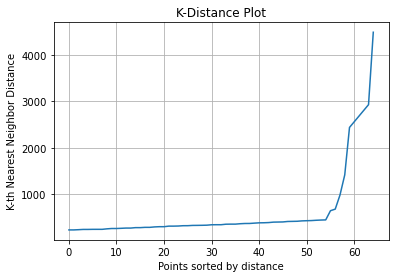

In [215]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming features_array is your data
k = 4  # Set this to min_samples for DBSCAN
features_array = np.array(features_list)
nbrs = NearestNeighbors(n_neighbors=k).fit(features_array)
distances, indices = nbrs.kneighbors(features_array)

# Get the distances to the k-th nearest neighbor
k_distances = distances[:, -1]  # Distance to the k-th nearest neighbor
k_distances = np.sort(k_distances)

# Plot
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('K-th Nearest Neighbor Distance')
plt.title('K-Distance Plot')
plt.grid()
plt.show()

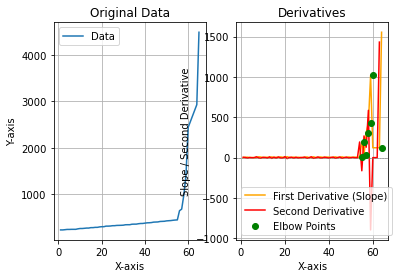

In [216]:
# detecting elbows
x_points = np.linspace(1, len(k_distances), len(k_distances))

# Calculate the first derivative (slope)
dy = np.diff(k_distances)  # Change in y
dx = np.diff(x_points)  # Change in x
slope = dy / dx   # First derivative

# Calculate the second derivative
d_slope = np.diff(slope)

# Find the elbow points based on the second derivative
threshold = np.mean(np.abs(d_slope))  # Simple threshold
elbow_points = np.where(np.abs(d_slope) > threshold)[0] + 1  # +1 to align with the original indices

# Original data
plt.subplot(1, 2, 1)
plt.plot(x_points, k_distances, label='Data')
plt.title('Original Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.legend()

# Slope and second derivative
plt.subplot(1, 2, 2)
plt.plot(x_points[:-1], slope, label='First Derivative (Slope)', color='orange')
plt.plot(x_points[:-2], d_slope, label='Second Derivative', color='red')
plt.scatter(x_points[elbow_points], slope[elbow_points-1], color='green', label='Elbow Points', zorder=5)
plt.axhline(y=0, color='gray', linestyle='--', lw=0.5)
plt.title('Derivatives')
plt.xlabel('X-axis')
plt.ylabel('Slope / Second Derivative')
plt.grid(True)
plt.legend()

In [217]:
k_distances[elbow_points]

array([ 453.87159397,  651.02649825,  685.1553728 ,  988.03000321,
       1420.10120614, 2438.61975636, 2927.27232164])

In [218]:
# Fit DBSCAN model
# One may need to tune 'eps' and 'min_samples'
# 'eps': the maximum distance between two samples
#   for them to be considered neighbors
# 'min_samples': the number of samples in a 
#   neighborhood for a point to be considered a 
#    core point
    
dbscan = DBSCAN(eps=453.0, min_samples=4)

# Flatten each molecule's coordinates into a single vector
#flattened_molecules = np.array([mol.flatten() for mol in molecules])

# Change format
features_array = np.array(features_list)

# Fit the model
labels = dbscan.fit_predict(features_array)  # Reshape if needed

# Print out the cluster labels for each molecule
print("Cluster labels:", labels)

Cluster labels: [-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0
  0  0 -1  0  0  0  0 -1 -1  0  0  0  0  0  0 -1  0]


In [220]:
len(labels)

65